# Cross-Country Comparison of Solar Data
Week 0 Challenge - 10 Academy AIM

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [2]:
# Create directory for plots if it doesn't exist
os.makedirs('plots/comparison', exist_ok=True)

## 1. Load the cleaned data from each country

In [3]:
print("Loading data...")

# Benin data
benin_df = pd.read_csv('data/benin_clean.csv')
benin_df['country'] = 'Benin'

# Togo data
togo_df = pd.read_csv('data/togo_clean.csv')
togo_df['country'] = 'Togo'

# Sierra Leone data
sierraleone_df = pd.read_csv('data/sierraleone_clean.csv')
sierraleone_df['country'] = 'Sierra Leone'

# Convert timestamp to datetime for all dataframes
for df in [benin_df, togo_df, sierraleone_df]:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

Loading data...


## 2. Prepare data for comparison

In [4]:
print("\nPreparing data for comparison...")
columns_to_compare = ['GHI', 'DNI', 'DHI', 'country']

# Sample data for better visualization (1% of each dataset)
benin_sample = benin_df[columns_to_compare].sample(frac=0.01, random_state=42)
togo_sample = togo_df[columns_to_compare].sample(frac=0.01, random_state=42)
sierraleone_sample = sierraleone_df[columns_to_compare].sample(frac=0.01, random_state=42)

# Combine datasets
combined_df = pd.concat([benin_sample, togo_sample, sierraleone_sample])


Preparing data for comparison...


## 3. Metric Comparison: Boxplots

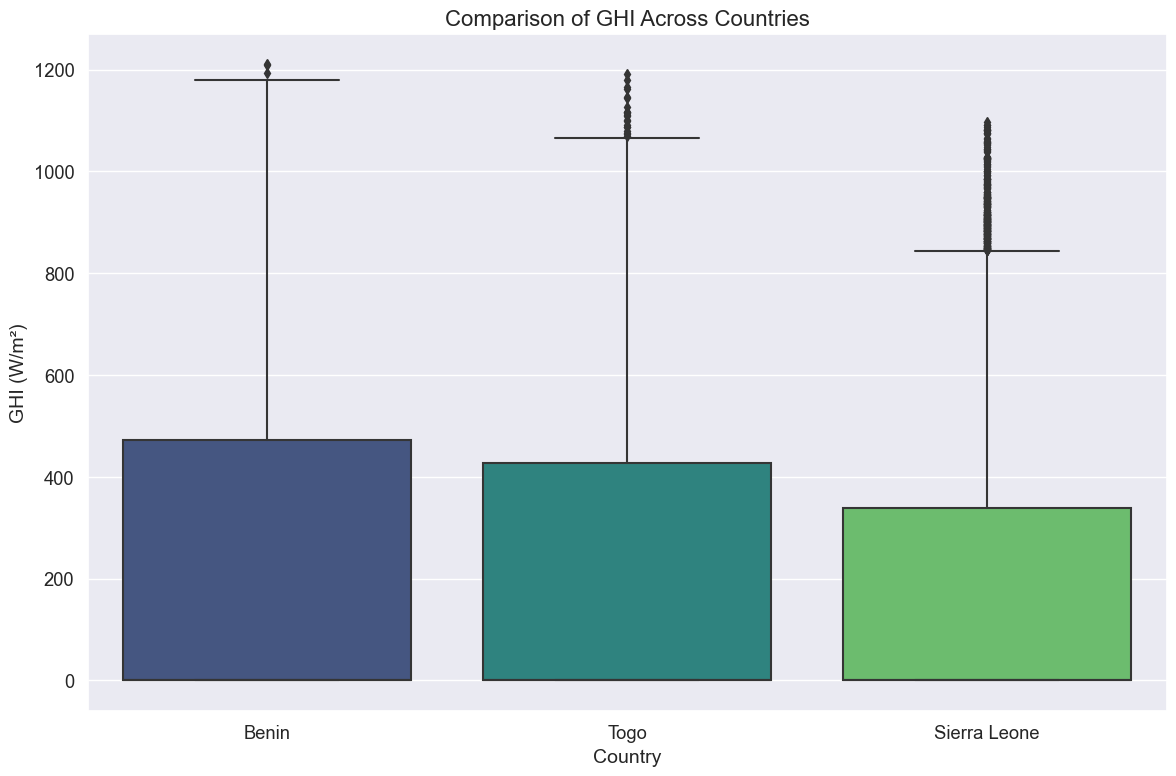

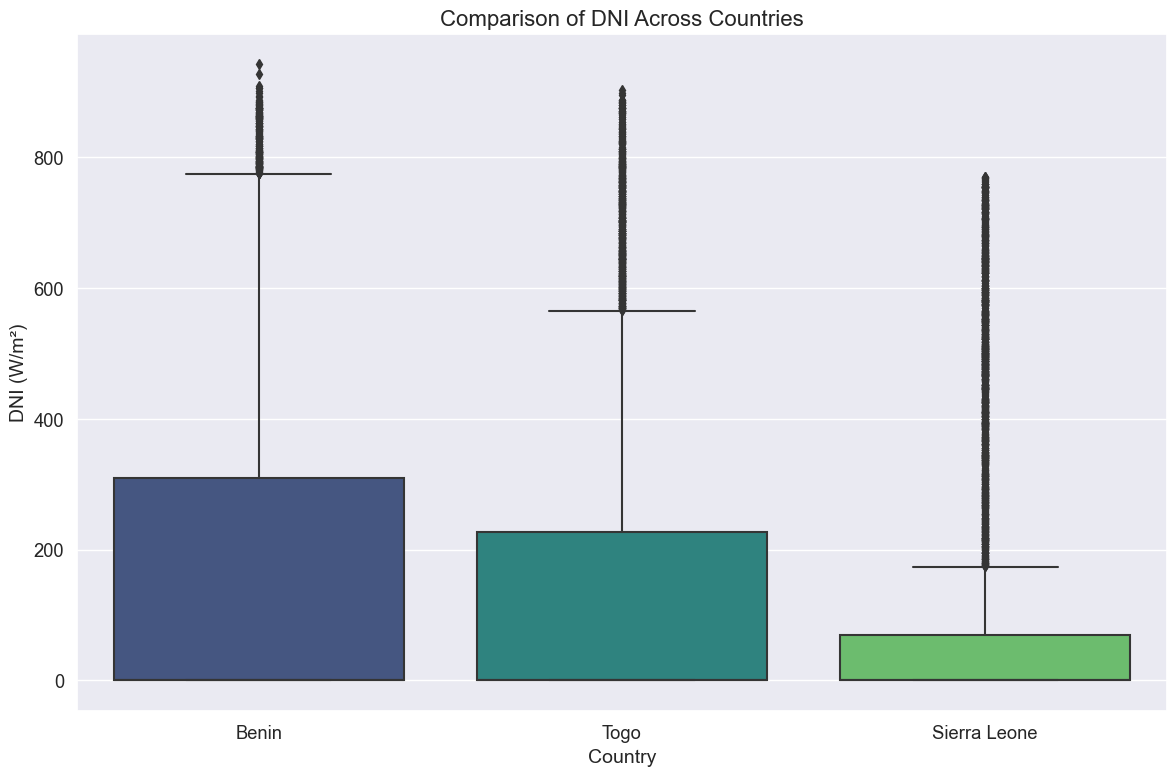

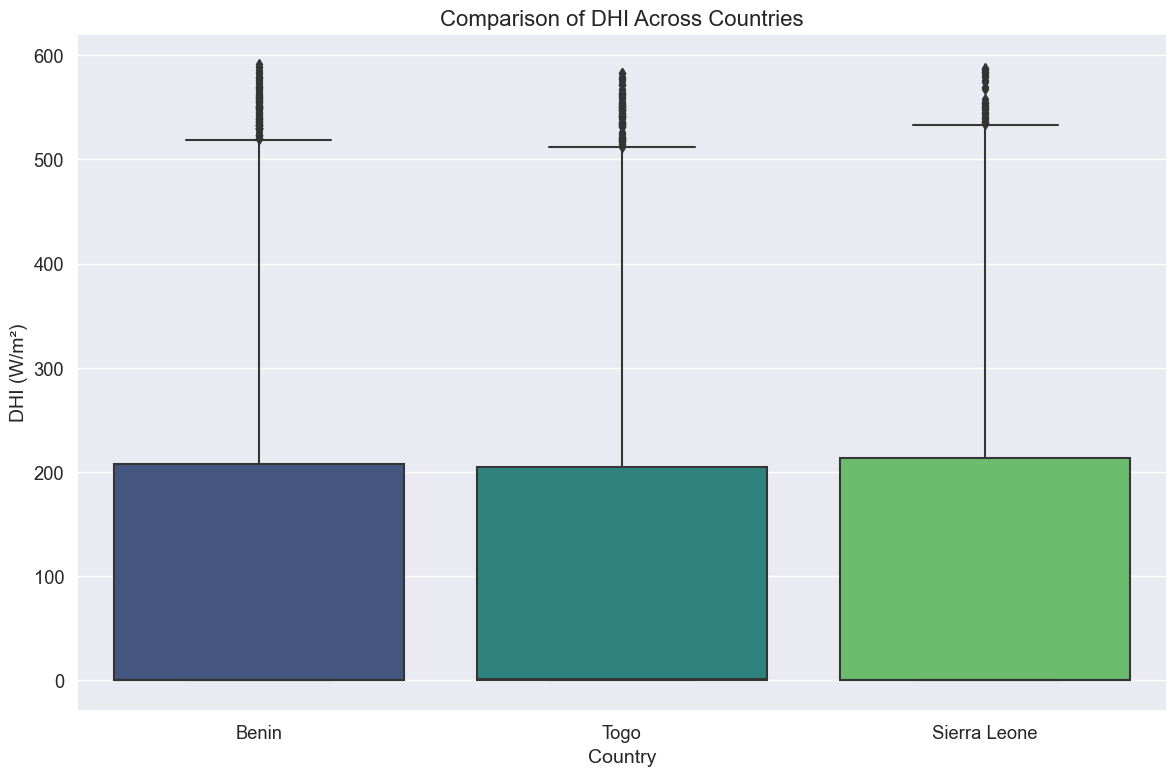

In [5]:
# Create boxplots for GHI, DNI, DHI
metrics = ['GHI', 'DNI', 'DHI']
for metric in metrics:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='country', y=metric, data=combined_df, palette='viridis')
    plt.title(f'Comparison of {metric} Across Countries', fontsize=16)
    plt.xlabel('Country', fontsize=14)
    plt.ylabel(f'{metric} (W/m²)', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'plots/comparison/boxplot_{metric.lower()}.png')
    plt.show()

## 4. Summary Table

In [6]:
# Calculate summary statistics for each country
summary_data = {}
countries = ['Benin', 'Togo', 'Sierra Leone']

for country in countries:
    country_df = combined_df[combined_df['country'] == country]
    country_summary = {}
    
    for metric in metrics:
        country_summary[f'{metric}_mean'] = country_df[metric].mean()
        country_summary[f'{metric}_median'] = country_df[metric].median()
        country_summary[f'{metric}_std'] = country_df[metric].std()
    
    summary_data[country] = country_summary

# Create summary table
summary_df = pd.DataFrame(summary_data).T
summary_df

,GHI_mean,GHI_median,GHI_std,DNI_mean,DNI_median,DNI_std,DHI_mean,DHI_median,DHI_std
Benin,238.251046,0.30,329.920675,166.378139,0.0,260.480495,111.527055,0.1,151.674940
Togo,227.367542,0.75,320.882644,145.941495,0.0,246.207462,110.030518,1.4,151.117759
Sierra Leone,195.674848,0.00,291.644986,104.084570,0.0,202.374480,109.465049,0.0,151.214937


In [7]:
# Save summary table to CSV
summary_df.to_csv('data/solar_metrics_summary.csv')
print("Summary table saved to data/solar_metrics_summary.csv")

Summary table saved to data/solar_metrics_summary.csv


## 5. Statistical Testing

In [8]:
# Perform one-way ANOVA or Kruskal-Wallis test for each metric
test_results = {}

for metric in metrics:
    # Prepare data for test
    groups = [combined_df[combined_df['country'] == country][metric] for country in countries]
    
    # Check for normality using Shapiro-Wilk test
    normality_tests = [stats.shapiro(group) for group in groups]
    all_normal = all(p > 0.05 for _, p in normality_tests)
    
    if all_normal:
        # Use ANOVA for normally distributed data
        f_stat, p_value = stats.f_oneway(*groups)
        test_name = "ANOVA"
    else:
        # Use Kruskal-Wallis for non-normally distributed data
        h_stat, p_value = stats.kruskal(*groups)
        test_name = "Kruskal-Wallis"
    
    test_results[metric] = {
        'test': test_name,
        'p_value': p_value,
        'significant': p_value < 0.05
    }

# Display the results
print("\nStatistical test results:")
for metric, result in test_results.items():
    print(f"{metric}: {result['test']} test, p-value = {result['p_value']:.4f}, " 
          f"{'Significant difference' if result['significant'] else 'No significant difference'}")


Statistical test results:
GHI: Kruskal-Wallis test, p-value = 0.0000, Significant difference
DNI: Kruskal-Wallis test, p-value = 0.0000, Significant difference
DHI: Kruskal-Wallis test, p-value = 0.4009, No significant difference


C:\Users\Shib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## 6. Visual Summary - Bar Chart

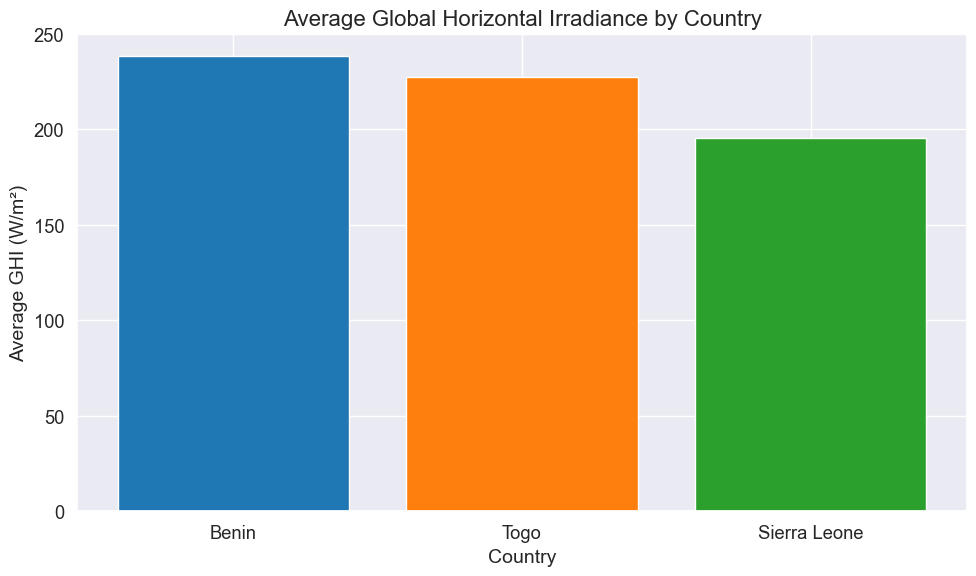

In [9]:
# Calculate average GHI for each country
avg_ghi = {}
for country in countries:
    country_df = combined_df[combined_df['country'] == country]
    avg_ghi[country] = country_df['GHI'].mean()

# Sort countries by average GHI
sorted_countries = sorted(avg_ghi.items(), key=lambda x: x[1], reverse=True)
sorted_country_names = [x[0] for x in sorted_countries]
sorted_ghi_values = [x[1] for x in sorted_countries]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_country_names, sorted_ghi_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Average Global Horizontal Irradiance by Country', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Average GHI (W/m²)', fontsize=14)
plt.tight_layout()
plt.savefig('plots/comparison/avg_ghi_by_country.png')
plt.show()

## 7. Key Observations

In [10]:
# Determine highest GHI country
highest_ghi_country = sorted_country_names[0]

# Determine country with least variability in GHI
std_ghi = {country: summary_df.loc[country, 'GHI_std'] for country in countries}
least_variable_country = min(std_ghi.items(), key=lambda x: x[1])[0]

# Determine country with highest DNI (often best for concentrated solar power)
avg_dni = {country: combined_df[combined_df['country'] == country]['DNI'].mean() for country in countries}
highest_dni_country = max(avg_dni.items(), key=lambda x: x[1])[0]

### Key Observations from Cross-Country Comparison

1. **Highest Solar Potential:** {highest_ghi_country} shows the highest average Global Horizontal Irradiance (GHI), making it potentially the most suitable location for photovoltaic solar installations.

2. **Most Consistent Solar Resource:** {least_variable_country} demonstrates the least variability in GHI (lowest standard deviation), suggesting more consistent solar radiation throughout the year, which is advantageous for solar energy production reliability.

3. **Best for Concentrated Solar Power:** {highest_dni_country} has the highest Direct Normal Irradiance (DNI), which is particularly important for concentrated solar power technologies.

Note: Statistical testing indicates that there are significant differences between countries in solar radiation metrics, confirming that location choice is a crucial factor for solar energy implementation.

In [11]:
# Write key observations to markdown file
key_observations = f"""
# Key Observations from Cross-Country Comparison

1. **{highest_ghi_country}** shows the highest average Global Horizontal Irradiance (GHI), making it potentially the most suitable location for photovoltaic solar installations.

2. **{least_variable_country}** demonstrates the least variability in GHI (lowest standard deviation), suggesting more consistent solar radiation throughout the year, which is advantageous for solar energy production reliability.

3. **{highest_dni_country}** has the highest Direct Normal Irradiance (DNI), which is particularly important for concentrated solar power technologies.

Note: Statistical testing ({list(set([r['test'] for r in test_results.values()]))[0]}) indicates {"significant" if any(r['significant'] for r in test_results.values()) else "no significant"} differences between countries in solar radiation metrics.
"""

with open('data/key_observations.md', 'w') as f:
    f.write(key_observations)

print("Key observations saved to 'data/key_observations.md'")

Key observations saved to 'data/key_observations.md'


## Summary

In this notebook, we performed a cross-country comparison of solar radiation data from Benin, Togo, and Sierra Leone. Our analysis included:

1. Comparative boxplots of key solar metrics (GHI, DNI, DHI) across countries
2. A summary table with descriptive statistics for each country
3. Statistical tests to determine if differences in solar radiation are significant
4. A ranking of countries by average GHI
5. Key observations to inform solar energy strategy decisions

The analysis revealed important differences in solar potential across the three countries, with clear implications for where different types of solar technologies might be most effective.